# Binning for DESI

In [1]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm
import pickle
from astropy import table
from astropy.table import Table, join
from specutils import SpectralRegion
from scipy.interpolate import BSpline, make_interp_spline, UnivariateSpline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Importing Catalogs

In [3]:
with open('bgs_clus_RM_gal_matched.pickle', 'rb') as handle:
    bgs_matched = pickle.load(handle)

In [4]:
bgs_matched.columns

<TableColumns names=('TARGETID','RA_BGS','DEC_BGS','Z_BGS','WEIGHT','flux_g_dered','flux_r_dered','flux_z_dered','flux_w1_dered','flux_w2_dered','ID','LAMBDA','Z_LAMBDA','R_LAMBDA','Z_SPEC_x','RA_x','DEC_x','MODEL_MAG_R_x','MODEL_MAGERR_R_x','RM_gal_flag','Z_SPEC_y','RA_y','DEC_y','R','P','MODEL_MAG_R_y','MODEL_MAGERR_R_y','geoFrac')>

In [5]:
fcols = ['g','r','z','w1','w2']
for col in fcols:
    #bgs_matched['flux_'+col.lower()+'_dered'] = bgs_matched['FLUX_'+col]/data['MW_TRANSMISSION_'+col]
    bgs_matched['r_dered'] = 22.5 - 2.5*np.log10(bgs_matched['flux_r_dered'])
    bgs_matched['g_dered'] = 22.5 - 2.5*np.log10(bgs_matched['flux_g_dered'])
    bgs_matched['gmr'] = bgs_matched['g_dered']-bgs_matched['r_dered']

In [6]:
np.max(bgs_matched['r_dered'])

20.219759

## Plotting

In [7]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling.polynomial import Chebyshev1D, Polynomial1D
from astropy.modeling.functional_models import Linear1D
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
import linetools

### Functions

In [24]:
'''
Performs the zDiff calculation and error measurements. 

zDiff is taken to be (z_BGS - z_bcg)/(1+z_bcg).
Errors are performed with Poisson noise. bins with 0 are assigned an error of 1. 

Input:
binCent: center of the bins
table: Astropy table of format bgs_matched. The cuts are performed outside the function. 
Table should contain columns 'Z_BGS', 'Z_SPEC_x' (BCG redshift)
numCount (bool): if False outputs the normalized pdf; if true outputs the number count per bin

Output:
val: The quantity per bin
y_err: the Poisson error
'''

def calc_zDiff(binBoundaries, table, numCount_bool=False):
    z_diff = (table['Z_BGS']-table['Z_SPEC_x'])/(1+table['Z_SPEC_x'])
    val, bin_edges= np.histogram(z_diff, bins=binBoundaries, density=True)
    #numCount, bin_edges = np.histogram(z_diff, bins=binBoundaries, density=False) 

    
    ## Propagating errors for bins with 0 error. This is the error on the pdf not the number count!
    bin_width = np.asarray([bin_edges[i+1]-bin_edges[i] for i in range(len(bin_edges[:-1]))])
    totNum = len(z_diff)
    #y_err = np.sqrt(numCount)/(bin_width*totNum)
    #y_err[np.where(y_err==0)] = 1
    #y_err = np.sqrt(val)

    numCount = val*bin_width*totNum

    if numCount_bool:
        y_err = np.sqrt(numCount)
        y_err[np.where(y_err==0)] = 1
        return numCount, y_err
        
    else:
        y_err = np.sqrt(numCount)/(bin_width*totNum)
        y_err[np.where(y_err==0)] = 1
        return val, y_err

In [25]:
'''
##This function is wrong
## Calculating the peculiar velocity taking into the Davis & Schrimgeour 2014 correction.

z_m: median redshift (for the cluster object)
z_obs: observed redshift for particular object

Output:
v_peculiar: in km/s
'''
def calc_vPec(z_m, z_obs):
    #q0 = -0.55
    #j0 = 1.0
    c = 2.99e5 ##km/s

    #v_median = c*z_m/(1+z_m)*(1+1./2*(1-q0)*z_m - 1./6*(1-q0-3*q0**2+j0)*z_m**2.)
    #v_obs = c*z_m/(1+z_obs)*(1+1./2*(1-q0)*z_obs - 1./6*(1-q0-3*q0**2+j0)*z_obs**2.)
    #v_peculiar = v_obs - v_median

    v_peculiar = (z_obs-z_m)*c

    return v_peculiar

In [26]:
'''
Outputs the continuum, considered to be the excess probability for np.abs(dz) > 0.02 using a Chebyshev polynomial fit. 

Parameters:
binBoundaries: list of bin edges
table: Astropy table of format bgs_matched. The cuts are performed outside the function. 
The table should contain columns 'Z_BGS', 'Z_SPEC_x' (BCG redshift)
binCent: center of the bins

Returns:
y_continuum_prob: the pdf of the continuum
'''

def calc_Continuum(binBoundaries, binCent, table):
    
    exclude_regions = [SpectralRegion(-0.02 * u.um, 0.02 * u.um)]
    y_data, y_err = calc_zDiff(binBoundaries, table)
    x_data_continuum = binCent
    
    spectrum = Spectrum1D(flux=y_data*u.Jy, spectral_axis=binCent*u.um)
    g1_fit = fit_generic_continuum(spectrum, model=Chebyshev1D(9), median_window=3, exclude_regions=exclude_regions)
    y_continuum_prob = g1_fit(binCent*u.um).value
       
    return y_continuum_prob


In [11]:
'''
Calculates the weights for IID * GeoFrac
'''
def calc_weights_all(binBoundaries, table, numCount_bool=False):
    z_diff = (table['Z_BGS']-table['Z_SPEC_x'])/(1+table['Z_SPEC_x'])
    weight = table['WEIGHT'] * table['geoFrac']
    val, bin_edges= np.histogram(weight, bins=binBoundaries, density=True)

    weight_list = []

    for i in range(len(bin_edges)-1):
        bin_low = bin_edges[i]; bin_high = bin_edges[i+1];
        filt = np.where((z_diff >= bin_low) & (z_diff < bin_high))
        curTable = table[filt]
        curWeight = np.mean(curTable['WEIGHT']/curTable['geoFrac'])
        weight_list = np.hstack((weight_list,curWeight))

    return binCent, weight_list

In [12]:
'''
Outputs ID, total spec richness w/o continuum removal, spec richness after continuum removal

'''

def calc_specRichness_individual(binBoundaries, binCent, table):
    x, weights_all = calc_weights_all(binBoundaries, table)
    bin_width = np.asarray([binBoundaries[i+1]-binBoundaries[i] for i in range(len(binBoundaries[:-1]))])
    y_continuum_prob = calc_Continuum(binBoundaries, binCent, table)
    continuum_prob_spl = UnivariateSpline(binCent, y_continuum_prob, s=0)
    pdf, y_err = calc_zDiff(binBoundaries, table, numCount_bool=False)
    totNum = len(table)
    
    bgs_groupedbyRM = table.group_by('ID')
    ID_list = []
    lambda_true_list = []
    lambda_tot_list = []
    for key, group in zip(bgs_groupedbyRM.groups.keys, bgs_groupedbyRM.groups):    
        
        pdf, y_err = calc_zDiff(binBoundaries, group, numCount_bool=False)
        ## Remove histograms with np.nan
        if np.any(np.isnan(pdf)):
            continue
        totNum = len(group)
        #numCount, y_err = calc_zDiff(binBoundaries, group, numCount_bool=True)
        lambda_true = np.sum((pdf-continuum_prob_spl(binCent))*bin_width*weights_all)*totNum
        lambda_tot = np.sum(pdf*bin_width*weights_all)*totNum 
        
        ID_list = np.hstack((ID_list, group['ID'][0]))
        lambda_tot_list = np.hstack((lambda_tot_list,lambda_tot))
        lambda_true_list = np.hstack((lambda_true_list,lambda_true))

    return ID_list, lambda_tot_list, lambda_true_list

In [13]:
'''
Outputs total spec richness w/o continuum removal, spec richness after continuum removal for stacked.
'''

def calc_specRichness_stacked(binBoundaries, binCent, table):
    x, weights_all = calc_weights_all(binBoundaries, table)
    bin_width = np.asarray([binBoundaries[i+1]-binBoundaries[i] for i in range(len(binBoundaries[:-1]))])
    y_continuum_prob = calc_Continuum(binBoundaries, binCent, table)
    continuum_prob_spl = UnivariateSpline(binCent, y_continuum_prob, s=0)
    pdf, y_err = calc_zDiff(binBoundaries, table, numCount_bool=False)
    totNum = len(table)
    numCluster = len(np.unique(table['ID']))
    
    if np.any(np.isnan(pdf)): 
        raise ValueError("Input value cannot be NaN.")

    lambda_true = np.sum((pdf-continuum_prob_spl(binCent))*bin_width*weights_all)*totNum/numCluster 
    lambda_tot = np.sum(pdf*bin_width*weights_all)*totNum/numCluster 

    return lambda_tot, lambda_true

### Binning Scheme

In [14]:
#binGap = 1e-5
wide_bin_1 = np.linspace(-0.1,-0.005,21, endpoint=False)
small_bin = np.linspace(-0.005,0.005,21, endpoint=False)
micro_bin = np.linspace(-0.005,0.005,31)
wide_bin_2 = np.linspace(0.005,0.1,21, endpoint=False)


binBoundaries = np.hstack((wide_bin_1, small_bin))
binBoundaries = np.hstack((binBoundaries, wide_bin_2))
binCent = np.asarray([(binBoundaries[i] + binBoundaries[i+1])/2 for i in range(len(binBoundaries)-1)])
binCent_micro = np.asarray([(micro_bin[i] + micro_bin[i+1])/2 for i in range(len(micro_bin)-1)])
bin_width = np.asarray([binBoundaries[i+1]-binBoundaries[i] for i in range(len(binBoundaries[:-1]))])

## None overlapping bins
assert len(set(binCent)) == len(binCent), "Overlapping bins"
assert len(set(binBoundaries)) == len(binBoundaries), "Overlapping bins"

In [15]:
#Bin by richness
lmda_bins = [[20,30],[30,50],[50,300]] #upper limit must match lower limit of next bin
## Bin by redshift
z_bins = [[0.15,0.2],[0.2,0.3],[0.3,0.4]]

In [16]:
lambda_tot, lambda_true = calc_specRichness_stacked(binBoundaries, binCent, bgs_matched)
rm_id, lambda_tot_list, lambda_true_list = calc_specRichness_individual(binBoundaries, binCent, bgs_matched)
lambda_tab = Table()
lambda_tab['ID'] = rm_id
lambda_tab['lambda_spec_tot'] = lambda_tot_list
lambda_tab['lambda_spec_true'] = lambda_true_list
bgs_matched = join(bgs_matched, lambda_tab, keys='ID', join_type='inner')

In [17]:
cutDict = {'All': np.full(len(bgs_matched), True), \
           r'$p_{\rm mem} > 0.0$': np.asarray(bgs_matched['RM_gal_flag'] & (bgs_matched['P'] > 0)), \
           #r'$p_{\rm mem} > 0.2$': np.asarray(bgs_matched['RM_gal_flag'] & (bgs_matched['P'] > 0.2)), \
           #r'$p_{\rm mem} > 0.4$': np.asarray(bgs_matched['RM_gal_flag'] & (bgs_matched['P'] > 0.4)), \
           #r'$p_{\rm mem} > 0.6$': np.asarray(bgs_matched['RM_gal_flag'] & (bgs_matched['P'] > 0.6)), \
           r'$p_{\rm mem} > 0.8$': np.asarray(bgs_matched['RM_gal_flag'] & (bgs_matched['P'] > 0.8))
          }

### Plot all

In [18]:
x_data_continuum = binCent
y_continuum_prob = calc_Continuum(binBoundaries, binCent, bgs_matched)

In [19]:
## Spline the continuum
smoothing_param = 0
continuum_prob_spl = UnivariateSpline(x_data_continuum, y_continuum_prob, s=smoothing_param)

In [20]:
### Plotting params
smoothing_param = 0
xlim_inset_low = -0.005; xlim_inset_high = 0.005
xlim_low = -0.1; xlim_high = 0.1
ylim_low = 0.05; ylim_high = 1e4
ylim_inset_low = 10; ylim_inset_high = 1e4
z_anchor = 0.4
shift_wide_val = 0.0002
shift_small_val = 0.0001
fontsize=14
alpha=0.5

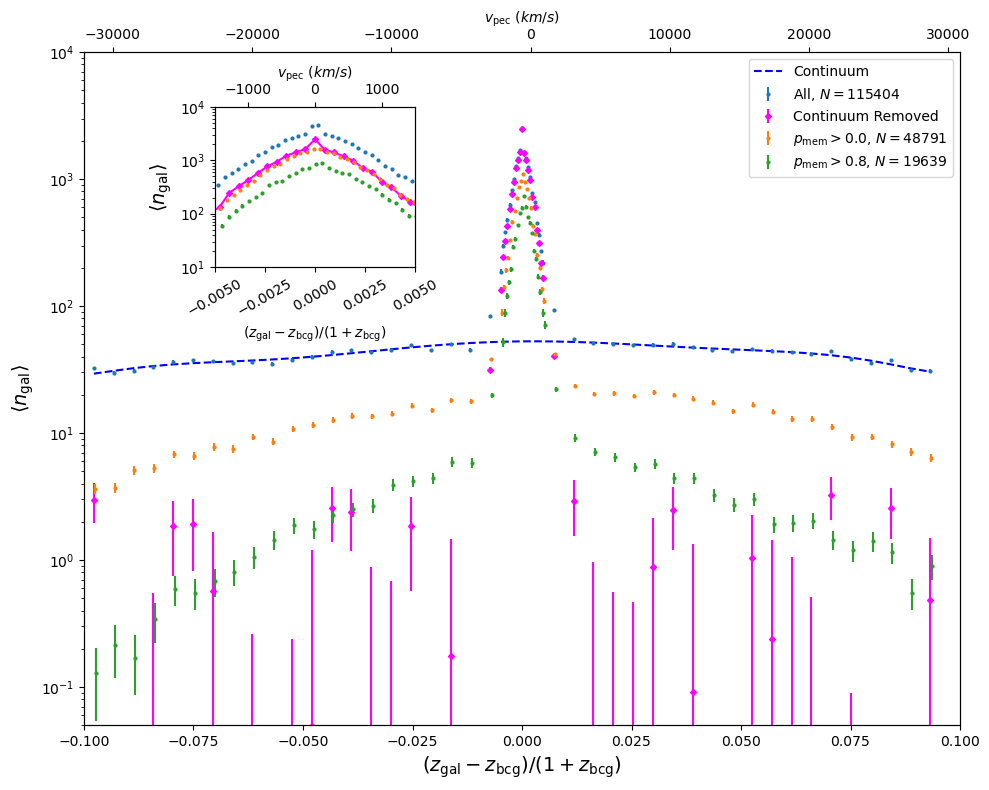

In [21]:
fig, ax1 = plt.subplots(figsize=(10,8), tight_layout=True)
left, bottom, width, height = [0.22, 0.66, 0.2, 0.2]
ax2 = ax1.twiny()
ax3 = fig.add_axes([left, bottom, width, height])
ax4 = ax3.twiny()
shift_small = 0; shift_wide = 0 
for key, val in cutDict.items():
    curTable = bgs_matched[val]
    val, y_err = calc_zDiff(binBoundaries, curTable)
    numTotal = len(curTable)
    numCluster = len(np.unique(curTable['ID']))
    val *= numTotal/numCluster
    y_err *= numTotal/numCluster
    x_data = binCent+shift_wide
    
    ##Plotting

    numText = r', $N={:d}$'.format(len(curTable))
    ax1.errorbar(x_data, val, yerr=y_err, linestyle='none', label=key+numText,  marker='o', markersize='2')

    
    v_pec = calc_vPec(0, x_data)
    ax2.errorbar(v_pec, val, yerr=y_err, visible=False)


    ##For inset plotting
    val_inset, y_err_inset = calc_zDiff(micro_bin, curTable)
    val_inset *= numTotal/numCluster
    y_err_inset *= numTotal/numCluster
    
    ax3.errorbar(binCent_micro+shift_small, val_inset, yerr=y_err_inset, \
                 linestyle='none', label=key+numText,  marker='o', markersize='2')

    shift_wide += shift_wide_val
    shift_small += shift_small_val

    ##Splining
    y_spl = UnivariateSpline(x_data, val, s=smoothing_param)
    y_err_spl = UnivariateSpline(x_data, y_err, s=smoothing_param)
    continuum_spl = continuum_prob_spl(x_data)*numTotal/numCluster
    y_continuum_removed = (y_spl(x_data)-continuum_spl)
    
    ##Plotting the continuum
    if key=='All':
        ax1.plot(x_data, continuum_spl, label='Continuum', linestyle='dashed', color='blue')
        ax1.errorbar(x_data, y_continuum_removed, yerr=y_err, linestyle='none', label='Continuum Removed', marker='D', markersize=3, color='magenta')
        ax3.errorbar(x_data, y_continuum_removed, yerr=y_err, marker='D', markersize=3, color='magenta')
        

ax1.legend()
ax1.set_yscale('log')
ax1.set_ylim([ylim_low,ylim_high])
#ax1.set_yscale('symlog', linthresh=5)
ax1.set_ylabel(r'$\langle n_{\rm gal} \rangle$', fontsize=fontsize)
ax1.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$", fontsize=fontsize)
ax2.set_xlabel(r"$v_{\rm pec}~(km/s)$")
ax1.set_xlim([xlim_low,xlim_high])
ax3.set_xlim([xlim_inset_low,xlim_inset_high])
ax4.set_xlim([calc_vPec(z_anchor, z_anchor+xlim_inset_low),calc_vPec(z_anchor,z_anchor+xlim_inset_high)])
ax3.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$")
ax4.set_xlabel(r"$v_{\rm pec}~(km/s)$")
ax3.set_xlabel(r"$(z_{\rm{gal}} - z_{\rm{bcg}})/(1+z_{\rm{bcg}})$")
ax3.set_yscale('log')
#ax3.set_ylim([10,500])
ax3.set_ylabel(r'$\langle n_{\rm gal} \rangle$', fontsize=fontsize)
ax3.set_ylim([ylim_inset_low, ylim_inset_high])
ax3.tick_params(axis='x', labelrotation=30)
#plt.savefig('doublePeak_dataBinned_prob.jpeg')
#ax2.set_visible('False')
plt.show()

### Binned by richness and redshift

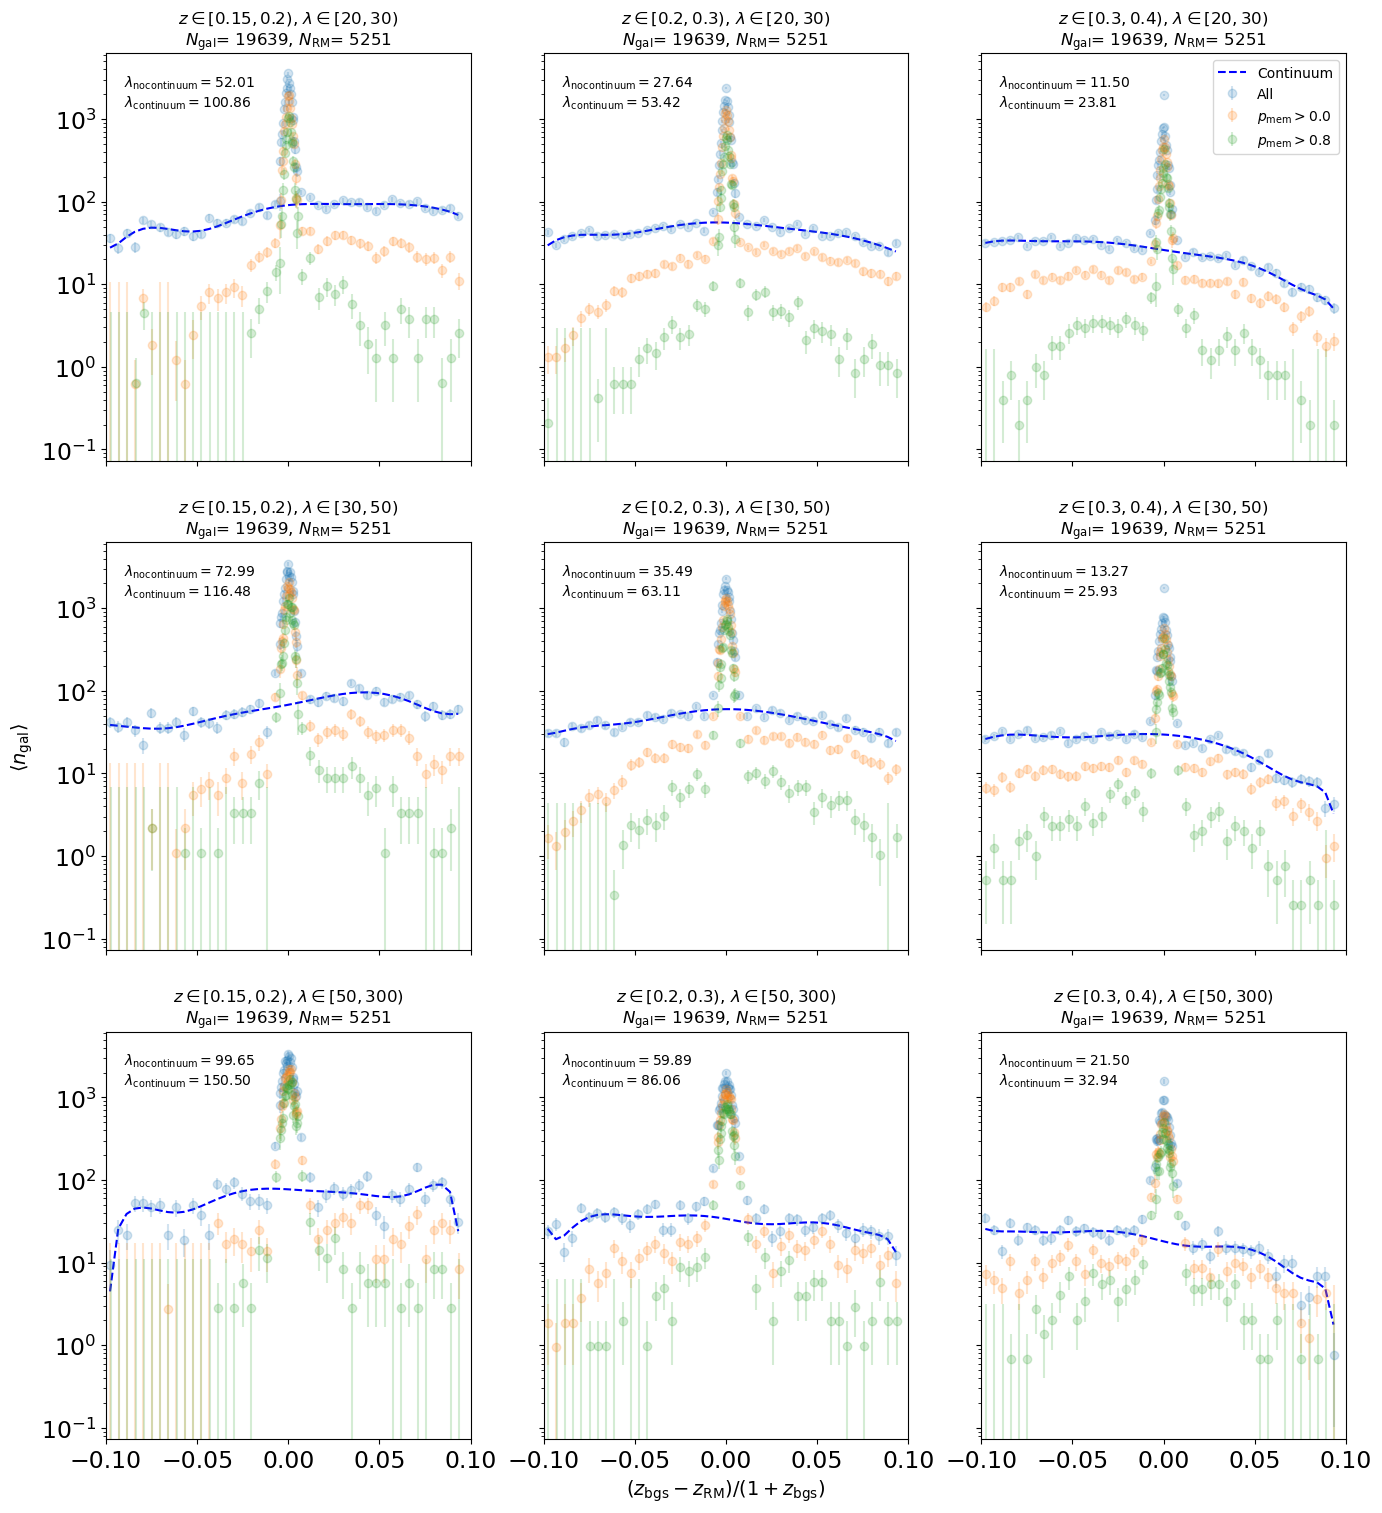

In [22]:
fig, ax = plt.subplots(nrows=len(lmda_bins), ncols=len(z_bins), figsize=(16,18), sharex='all', sharey='all')

shift_wide = 0
for key, val in cutDict.items():
    galFilter = bgs_matched[val]
    for i, lmda_bin in enumerate(lmda_bins):
        for j, z_bin in enumerate(z_bins):

            ##Apply binning
            cut = (galFilter['LAMBDA'] >= lmda_bin[0]) & (galFilter['LAMBDA'] < lmda_bin[1])
            cut &=(galFilter['Z_SPEC_x'] >= z_bin[0]) & (galFilter['Z_SPEC_x'] < z_bin[1])
            curTable = galFilter[cut]
            
            x_data = binCent + shift_wide
            y_data, y_err = calc_zDiff(binBoundaries, curTable)
    
            numTotal = len(curTable)
            numCluster = len(np.unique(curTable['ID']))
            ##Skip if no bins
            if numTotal == 0:
                continue

            ## Change from prob to average number count density per cluster
            y_data *= numTotal/numCluster
            y_err *= numTotal/numCluster


            if key=='All':
                ##Continuum removal
                y_continuum_prob = calc_Continuum(binBoundaries, binCent, curTable)
                continuum_prob_spl = UnivariateSpline(x_data, y_continuum_prob, s=smoothing_param)
                continuum_spl = continuum_prob_spl(x_data)*numTotal/numCluster
                ax[i,j].plot(x_data, continuum_spl, label='Continuum', linestyle='dashed', color='blue')

                ## Weighted spectroscopic richness
                lambda_tot, lambda_true = calc_specRichness_stacked(binBoundaries, binCent, curTable)
                textstr = r'$\lambda_{\rm nocontinuum} = $' + '{:.2f}'.format(lambda_true) +'\n' + \
                          r'$\lambda_{\rm continuum} = $' + '{:.2f}'.format(lambda_tot)

                ax[i,j].text(0.05, 0.95, textstr, fontsize=10, transform=ax[i,j].transAxes, verticalalignment='top')#, bbox=props)
            
            ax[i,j].errorbar(x_data, y_data, yerr= y_err, linestyle='none', marker='o', alpha=0.2, label=key)
            ax[i,j].set_yscale('log')
            #ax[i,j].set_yscale('symlog', linthresh=1)
            ax[i,j].set_xlim([-0.1,0.1])
                #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=17)
            ax[i,j].set_title(r'$z \in [{:.2g}, {:.2g})$, '.format(z_bin[0], z_bin[1],fontsize=12)+ \
                                  r'$\lambda \in [{:d},{:d})$'.format(lmda_bin[0],lmda_bin[1],fontsize=12) + '\n' + \
                                  r'$N_{\rm gal}$' + '= {:d}'.format(len(galFilter)) \
                                  + r', $N_{\rm RM}$' + '= {:d}'.format(len(np.unique(galFilter['ID']))))
                #ax[i,j].axhline(0.0, linestyle='--')

    ##Shifting for better visuals
    shift_wide += shift_wide_val
            
    
ax[1,0].set_ylabel(r'$\langle n_{\rm gal} \rangle$', fontsize=fontsize)
ax[2,1].set_xlabel(r"$(z_{\rm{bgs}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$"  , fontsize=fontsize)  
ax[0,2].legend(fontsize=10, loc='best')
plt.savefig('projection_richness_redshift_binned.png')
plt.show()   

## Apply a luminosity cut

* See how the fraction changes as a function of limiting magnitude.
* Convert from apparent magnitude to luminosity
* Compare and contrast with J.Myles


In [23]:
## limiting mag
'''
From Rykoff+14.

L=0.2 is the ratio of L_* converted to apparent magnitude.
For z < 0.5
'''

def limit_m_r_Rykoff14(z, L=0.2):
    L_default = 0.2 ##0.2 L_star for Schechter luminosity function
    lnz = np.log(z)
    limiting_mag = 22.44 + +3.36*lnz+0.273*lnz**2 - 0.0618 * lnz**3 - 0.0227 * lnz**4
    limiting_mag -= 2.5*np.log10(L/L_default)
    return limiting_mag

'''
L=0.2 is the ratio of L_star.
Worked in redshift range 0.1-0.4
'''
def limit_m_r_Wang24(z, L=0.2):
    #L_default = 0.2 ##0.2 L_star for Schechter luminosity function

    ## This is limiting magnitude for L_*
    limiting_mag = -210.58160466*z**4 + 273.97978246*z**3 -144.02312011*z**2 + 43.56079261*z + 12.57003541 
    limiting_mag -= 2.5*np.log10(L) ## This is for fractional L_star
    return limiting_mag

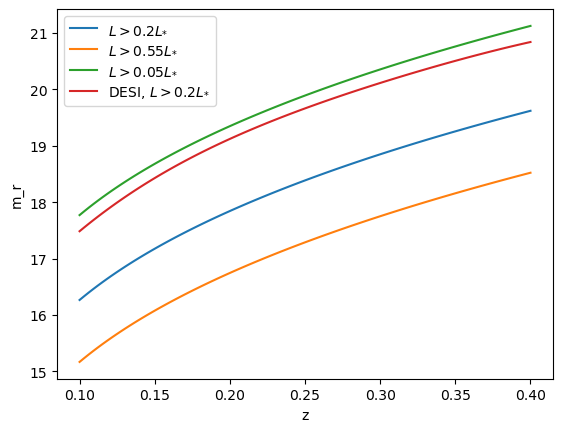

In [29]:
z = np.linspace(0.1,0.4,100)
lim_mr_pt2 = limit_m_r_Rykoff14(z, L = 0.2)
lim_mr_pt55 = limit_m_r_Rykoff14(z, L = 0.55)
lim_mr_pt5 = limit_m_r_Rykoff14(z, L = 0.05)
plt.plot(z, lim_mr_pt2, label=r'$L > 0.2L_{*}$')
plt.plot(z, lim_mr_pt55, label=r'$L > 0.55L_{*}$')
plt.plot(z, lim_mr_pt5, label=r'$L > 0.05L_{*}$')
plt.plot(z, limit_m_r_Wang24(z), label =r'DESI, $L > 0.2L_{*}$')
plt.legend(loc='best')
plt.xlabel('z')
plt.ylabel('m_r')
plt.show()

In [ ]:
L_lim = [0.05,0.2,0.55]

In [ ]:
for l_lim_cur in iter(L_lim):

    cut = bgs_matched['r_dered'] < limit_m_r_Rykoff14(bgs_matched['Z_SPEC_x'], L = l_lim_cur)
    curTable = bgs_matched[cut]
    plt.hist(curTable['r_dered'], bins=100, histtype='step', label=r'SDSS, $L < {:.2f}L_*$, N={:d}'.format(l_lim_cur, len(curTable)))

## For DESI CUt
cut = bgs_matched['r_dered'] < limit_m_r_Wang24(bgs_matched['Z_SPEC_x'], L = 0.2)
curTable = bgs_matched[cut]
plt.hist(curTable['r_dered'], bins=100, histtype='step', label=r'DESI, $L < {:.2f}L_*$, N={:d}'.format(0.2, len(curTable)))

plt.hist(bgs_matched['r_dered'], bins=100, histtype='step', label=r'No cut, N={:d}'.format(len(bgs_matched)))
plt.axvline(19.5, linestyle='dashed', color='black')
plt.legend()
plt.xlabel('m_r')
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=len(lmda_bins), ncols=len(z_bins), figsize=(16,18), sharex='all', sharey='all')

shift_wide = 0
for i, lmda_bin in enumerate(lmda_bins):
    for j, z_bin in enumerate(z_bins):
        ##Apply binning
        cut = (bgs_matched['LAMBDA'] >= lmda_bin[0]) & (bgs_matched['LAMBDA'] < lmda_bin[1])
        cut &=(bgs_matched['Z_SPEC_x'] >= z_bin[0]) & (bgs_matched['Z_SPEC_x'] < z_bin[1])
        binnedTable = bgs_matched[cut]
        numTotal = len(binnedTable)
        numCluster = len(np.unique(binnedTable['ID']))
        ##Skip if no bins
        if numTotal == 0:
            continue

        ax[i,j].set_title(r'$z \in [{:.2g}, {:.2g})$, '.format(z_bin[0], z_bin[1],fontsize=12)+ \
                            r'$\lambda \in [{:d},{:d})$'.format(lmda_bin[0],lmda_bin[1],fontsize=12) + '\n' + \
                            r'$N_{\rm gal}$' + '= {:d}'.format(len(binnedTable)) \
                            + r', $N_{\rm RM}$' + '= {:d}'.format(len(np.unique(binnedTable['ID']))))

        x_data = binCent + shift_wide
        y_data, y_err = calc_zDiff(binBoundaries, binnedTable)
        

        ## Change from prob to average number count density per cluster
        y_data *= numTotal/numCluster
        y_err *= numTotal/numCluster
    
                
        ax[i,j].errorbar(x_data, y_data, yerr=y_err, linestyle='none', marker='o', alpha=0.2, label=r'No cut')
        ax[i,j].set_yscale('log')
        #ax[i,j].set_yscale('symlog', linthresh=1)
        ax[i,j].set_xlim([-0.1,0.1])
                #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
        ax[i,j].tick_params(axis='both', which='major', labelsize=17)

                    #ax[i,j].axhline(0.0, linestyle='--')

        
        for l_lim_cur in iter(L_lim):
            shift_wide += shift_wide_val
            ##Different luminosity thresholds
            cut = binnedTable['r_dered'] < limit_m_r_Wang24(binnedTable['Z_SPEC_x'], L = l_lim_cur)
            curTable = binnedTable[cut]
                
            x_data = binCent + shift_wide
            y_data, y_err = calc_zDiff(binBoundaries, curTable)
        

            ## Change from prob to average number count density per cluster
            y_data *= numTotal/numCluster
            y_err *= numTotal/numCluster
    
                
            ax[i,j].errorbar(x_data, y_data, yerr=y_err, linestyle='none', marker='o', markersize=1, \
                alpha=0.5, label=r'$L < {:.2f}L_*$'.format(l_lim_cur))
            ax[i,j].set_yscale('log')
            #ax[i,j].set_yscale('symlog', linthresh=1)
            ax[i,j].set_xlim([-0.1,0.1])
                #ax[i,j].hist(z_diff, bins=binBoundaries, density=True)
            ax[i,j].tick_params(axis='both', which='major', labelsize=17)

                    #ax[i,j].axhline(0.0, linestyle='--')
            
        ##Shifting for better visuals

                
    
ax[1,0].set_ylabel(r'$\langle n_{\rm gal} \rangle$', fontsize=fontsize)
ax[2,1].set_xlabel(r"$(z_{\rm{bgs}} - z_{\rm{RM}})/(1+z_{\rm{bgs}})$"  , fontsize=fontsize)  
ax[0,2].legend(fontsize=10, loc='best')
plt.savefig('projection_richness_redshift_binned_luminositycut.png')
plt.show()   

## Weighted spectroscopic richness
Create functions for weighted richness. Compare weighted spec z richness with RM richness.

Todo: Need to further weigh by z_max

In [ ]:
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18
from astropy.cosmology import z_at_value
cosmo = Planck18

##Weight by V_max
z =bgs_matched['Z_SPEC_x'] * cu.redshift
dL = z.to(u.pc, cu.redshift_distance(Planck18, kind="luminosity")).value ##in pc
distmod = 5*np.log10(dL/10)
M_r = bgs_matched['r_dered'] - distmod

In [ ]:
plt.hist(M_r)
plt.xlabel('M_r')

In [ ]:
distmod_vmax = 20.2 - M_r ##Highest magnitude cut
dL_vmax = 10**(distmod/5 + 1)/1e6 * u.Mpc #in Mpc
plt.hist(dL_vmax)
plt.show()

In [ ]:
# Find redshift from luminosity distance
redshift_vmax = dL_vmax.to(cu.redshift, cu.redshift_distance(Planck18, kind="comoving", zmax=1))
print(f"Redshift: {redshift_vmax}")

# Calculate comoving distance
dC_vmax = redshift_vmax.to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))
dC = (bgs_matched['Z_SPEC_x']* cu.redshift).to(u.Mpc, cu.redshift_distance(Planck18, kind="comoving"))
print(f"Comoving distance: {dC_vmax}")

In [ ]:
v_max_weight = dC**3/dC_vmax.value**3

In [ ]:
bgs_matched['vmax_weight'] = v_max_weight

In [ ]:
## Include v_max into the richness proxy

In [ ]:
plt.hist(bgs_matched['vmax_weight'], bins=100)
plt.xlabel('V/Vmax')
plt.show()

In [ ]:
xline = np.linspace(0,300,100)
fig, ax =  plt.subplots()
#using_datashader(ax, bgs_matched['LAMBDA'], bgs_matched['lambda_spec_true'])
plt.scatter(bgs_matched['LAMBDA'], bgs_matched['lambda_spec_true'], s=5, alpha=0.3, label='w/o continuum')
#plt.scatter(bgs_matched['LAMBDA'], bgs_matched['lambda_spec_tot'], s=5, alpha=0.3, label='w/ continuum')
#plt.scatter(bgs_matched['LAMBDA'], bgs_matched['lambda_spec_true']*bgs_matched['vmax_weight'], s=5, alpha=0.3, label='Vmax correction')
plt.plot(xline, xline, linestyle='dashed', color='black')
plt.xlabel(r'RM Richness')
plt.ylabel(r'Weighted spec richness')
plt.yscale('log'); plt.xscale('log')
plt.xlim([20,300])
plt.legend()
plt.show()

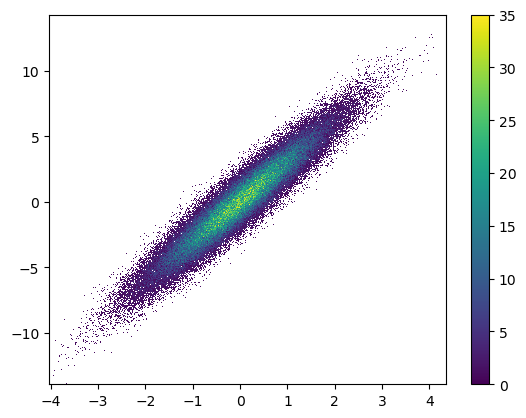

In [100]:
import datashader as ds
from datashader.mpl_ext import dsshow
import pandas as pd


def using_datashader(ax, x, y):

    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        vmin=0,
        vmax=35,
        norm="linear",
        aspect="auto",
        ax=ax,
    )

    plt.colorbar(dsartist)


fig, ax = plt.subplots()
using_datashader(ax, x, y)
plt.show()

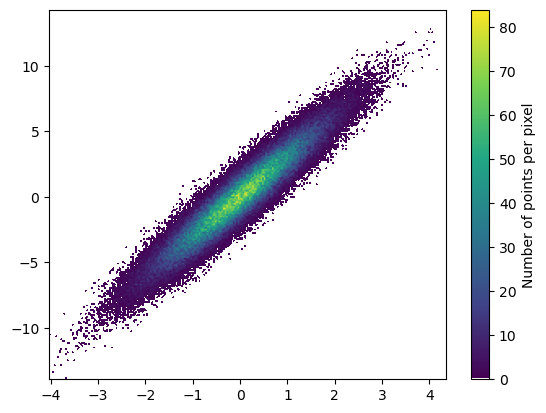

In [96]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

# Fake data for testing
x = np.random.normal(size=100000)
y = x * 3 + np.random.normal(size=100000)
fig = plt.figure()
using_mpl_scatter_density(fig, x, y)
plt.show()

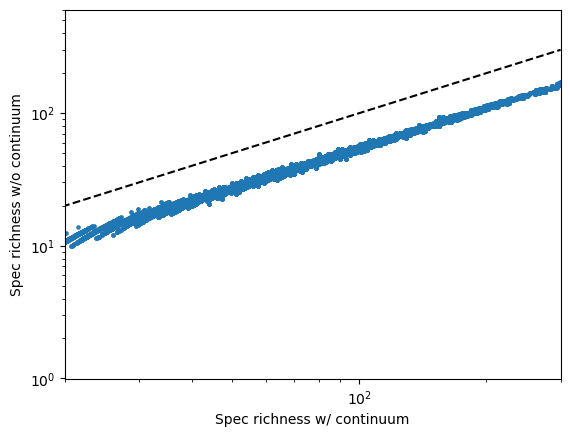

In [130]:
xline = np.linspace(0,300, 100)
plt.scatter(bgs_matched['lambda_spec_tot'], bgs_matched['lambda_spec_true'], s=5, alpha=0.3)
plt.plot(xline, xline, linestyle='dashed', color='black')
plt.xlabel(r'Spec richness w/ continuum')
plt.ylabel(r'Spec richness w/o continuum')
plt.yscale('log'); plt.xscale('log')
plt.xlim([20,300])
plt.show()

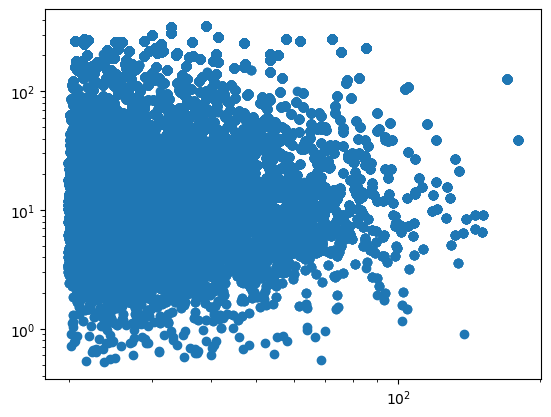

In [94]:
plt.scatter(bgs_matched['LAMBDA'], bgs_matched['lambda_spec_true']*bgs_matched['vmax_weight'])
plt.yscale('log')
plt.xscale('log')
plt.show()